In [27]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pylab as plt
import warnings
import pickle
import torch.nn as nn

from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
labels = pd.read_csv("annotations.csv")

In [30]:
labels.head()

,image,class
0,images/p7FhNESI-2TX5-aXiT-9nNv-f7LJlzc9BgqO.jpg,artificial_roughness
1,images/XJV2G0zl-scMm-HsbL-ovdy-J4mvzVQBO5uF.jpg,artificial_roughness
2,images/Yp1H0brV-VXZB-SZTa-PcFZ-Nes25RWxLgM4.jpg,artificial_roughness
3,images/VhuQ8Uqi-XxbK-TJwS-j5RN-ApJqVTBg0lbZ.jpg,artificial_roughness
4,images/LudjvYTM-V03e-BeaZ-6Sfj-bpeRzYmtG8Ew.jpg,artificial_roughness


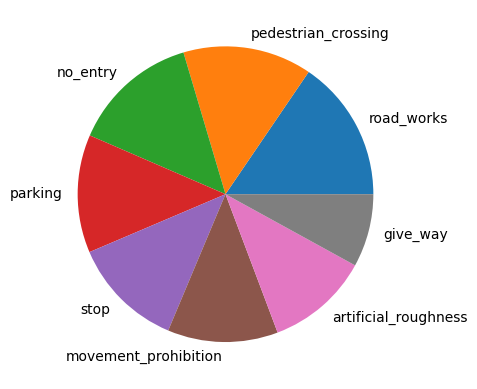

In [31]:
plt.pie(labels["class"].value_counts(), labels=labels["class"].value_counts().index);

In [32]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [33]:
DATA_MODES = ['train', 'val']
RESCALE_SIZE = 50
BATCH_SIZE = 30

DEVICE = torch.device("cuda")

In [34]:
import cv2
img = cv2.imread("drive/MyDrive/" + "images/ngT0ipJE-biuj-d81S-UoZW-iAGFEPdJcsV0.jpg")
print(img.shape)

(43, 50, 3)


In [35]:
class ImagesDataset(Dataset):
    def __init__(self, files, mode, images_labels):
        super().__init__()
        self.files = files
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = images_labels
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', '+wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = cv2.imread(str(file))
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

            ])
        x = self.load_sample(self.files[index])
        # x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [36]:
def imshow(inp, title=None, plt_ax=plt):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [37]:
TRAIN_DIR = Path("drive/MyDrive/" + 'images/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

In [38]:
from sklearn.model_selection import train_test_split

train_val_labels = [
    labels.loc[labels.image == "images/" + path.name].iloc[0]["class"]
    for path in train_val_files
]
train_files, val_files = train_test_split(
    train_val_files, test_size=0.25, stratify=train_val_labels
)
# train_files, val_files = train_val_files[:-1], [train_val_files[-1]]

In [39]:
val_labels = [
    labels.loc[labels.image == "images/" + path.name].iloc[0]["class"]
    for path in val_files
]

In [40]:
val_dataset = ImagesDataset(
    val_files, mode='val',
    images_labels=val_labels
)

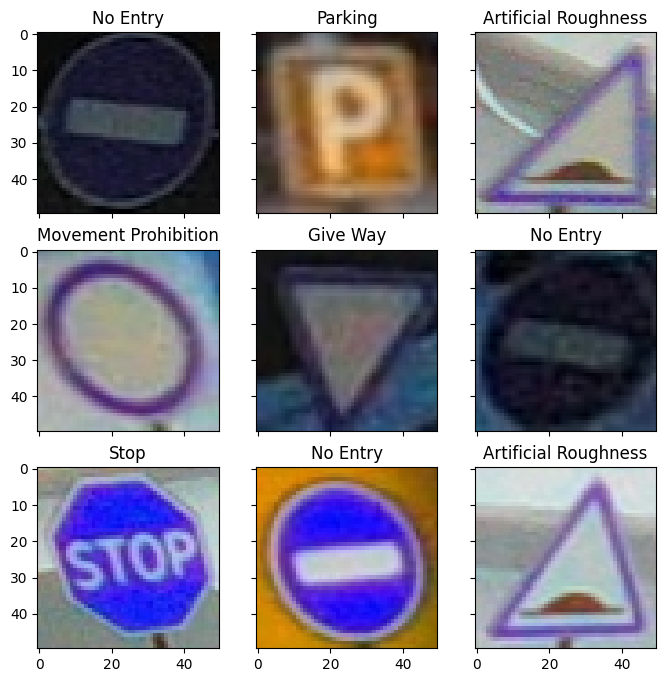

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(val_dataset)))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(),
          title=img_label,plt_ax=fig_x)

In [42]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.nn.functional.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    # scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [43]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data, dtype=torch.float32)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [44]:

def train(train_data, val_data, model, epochs, batch_size):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.0005)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler=scheduler)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [45]:

def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [46]:
n_classes = len(np.unique(train_val_labels))

In [47]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=1),
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=2),
        )
        self.flat = nn.Flatten()
        self.out = nn.Sequential(
            nn.Linear(96, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.Linear(24, n_classes)
        )


    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.conv3(x)
        # print(x.shape)
        x = self.conv4(x)
        # print(x.shape)
        x = self.conv5(x)
        # print(x.shape)
        x = self.flat(x)
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [56]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :8
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [57]:
train_labels = [
    labels.loc[labels.image == "images/" + path.name].iloc[0]["class"]
    for path in train_files
]

In [58]:
if val_dataset is None:
    val_dataset = ImagesDataset(val_files, mode='val', images_labels=val_labels)

train_dataset = ImagesDataset(train_files, mode='train', images_labels=train_labels)

In [59]:
import warnings
warnings.filterwarnings("ignore")


In [60]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=19, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/19 [00:00<?, ?it/s]

loss 1.2301491834469978


epoch:   5%|▌         | 1/19 [00:04<01:18,  4.33s/it]


Epoch 001 train_loss: 1.2301     val_loss 0.8512 train_acc 0.6848 val_acc 0.8452
loss 0.30061922121225604


epoch:  11%|█         | 2/19 [00:08<01:16,  4.50s/it]


Epoch 002 train_loss: 0.3006     val_loss 0.1242 train_acc 0.9199 val_acc 0.9623
loss 0.11891015713405333


epoch:  16%|█▌        | 3/19 [00:13<01:10,  4.41s/it]


Epoch 003 train_loss: 0.1189     val_loss 0.0595 train_acc 0.9649 val_acc 0.9901
loss 0.03141604997803587


epoch:  21%|██        | 4/19 [00:17<01:05,  4.38s/it]


Epoch 004 train_loss: 0.0314     val_loss 0.0519 train_acc 0.9894 val_acc 0.9881
loss 0.011284448526759588


epoch:  26%|██▋       | 5/19 [00:22<01:02,  4.50s/it]


Epoch 005 train_loss: 0.0113     val_loss 0.0220 train_acc 0.9993 val_acc 0.9960
loss 0.005804947689399185


epoch:  32%|███▏      | 6/19 [00:26<00:59,  4.56s/it]


Epoch 006 train_loss: 0.0058     val_loss 0.0823 train_acc 0.9987 val_acc 0.9782
loss 0.015061139575103976


epoch:  37%|███▋      | 7/19 [00:31<00:54,  4.55s/it]


Epoch 007 train_loss: 0.0151     val_loss 0.0323 train_acc 0.9960 val_acc 0.9901
loss 0.005370160674546006


epoch:  42%|████▏     | 8/19 [00:36<00:50,  4.59s/it]


Epoch 008 train_loss: 0.0054     val_loss 0.0225 train_acc 0.9987 val_acc 0.9940
loss 0.0063959781907534305


epoch:  47%|████▋     | 9/19 [00:40<00:45,  4.54s/it]


Epoch 009 train_loss: 0.0064     val_loss 0.0265 train_acc 0.9980 val_acc 0.9881
loss 0.0015768291177785114


epoch:  53%|█████▎    | 10/19 [00:45<00:40,  4.51s/it]


Epoch 010 train_loss: 0.0016     val_loss 0.0196 train_acc 1.0000 val_acc 0.9940
loss 0.0005646918471029494


epoch:  58%|█████▊    | 11/19 [00:49<00:36,  4.59s/it]


Epoch 011 train_loss: 0.0006     val_loss 0.0183 train_acc 1.0000 val_acc 0.9940
loss 0.00042612605389178305


epoch:  63%|██████▎   | 12/19 [00:54<00:32,  4.60s/it]


Epoch 012 train_loss: 0.0004     val_loss 0.0186 train_acc 1.0000 val_acc 0.9960
loss 0.00035346765620464346


epoch:  68%|██████▊   | 13/19 [00:59<00:27,  4.58s/it]


Epoch 013 train_loss: 0.0004     val_loss 0.0184 train_acc 1.0000 val_acc 0.9960
loss 0.00030428158112912247


epoch:  74%|███████▎  | 14/19 [01:03<00:22,  4.55s/it]


Epoch 014 train_loss: 0.0003     val_loss 0.0188 train_acc 1.0000 val_acc 0.9960
loss 0.00027062850335974475


epoch:  79%|███████▉  | 15/19 [01:07<00:17,  4.45s/it]


Epoch 015 train_loss: 0.0003     val_loss 0.0189 train_acc 1.0000 val_acc 0.9960
loss 0.00024487757267983975


epoch:  84%|████████▍ | 16/19 [01:12<00:13,  4.41s/it]


Epoch 016 train_loss: 0.0002     val_loss 0.0188 train_acc 1.0000 val_acc 0.9960
loss 0.00022421733563725792


epoch:  89%|████████▉ | 17/19 [01:16<00:08,  4.47s/it]


Epoch 017 train_loss: 0.0002     val_loss 0.0189 train_acc 1.0000 val_acc 0.9960
loss 0.0002030127163608682


epoch:  95%|█████████▍| 18/19 [01:20<00:04,  4.44s/it]


Epoch 018 train_loss: 0.0002     val_loss 0.0188 train_acc 1.0000 val_acc 0.9960
loss 0.00018631455359896816


epoch: 100%|██████████| 19/19 [01:25<00:00,  4.51s/it]


Epoch 019 train_loss: 0.0002     val_loss 0.0189 train_acc 1.0000 val_acc 0.9960


In [61]:
torch.save(
    simple_cnn.state_dict(), 'model.pth'
)

In [62]:
loss, acc, val_loss, val_acc = zip(*history)

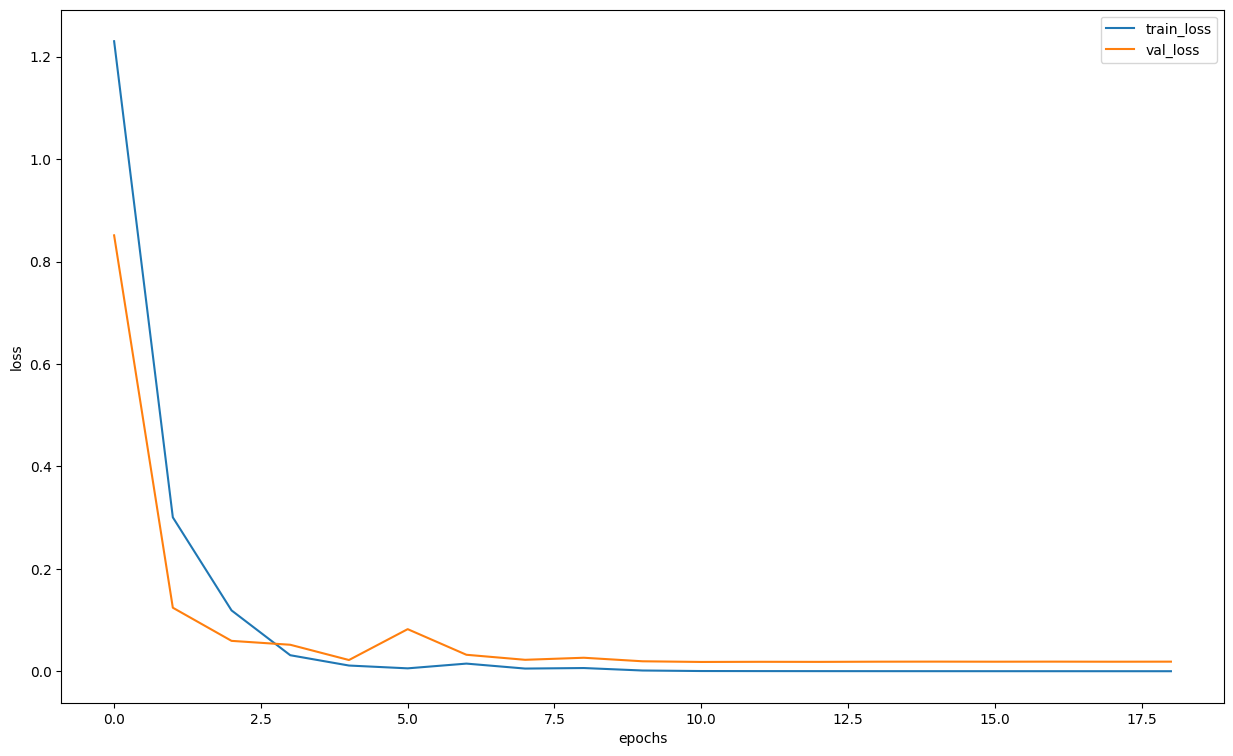

In [63]:

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [64]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [65]:

idxs = list(map(int, np.arange(0,len(train_dataset))))
imgs = [train_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [66]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))


In [67]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [train_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [68]:
from sklearn.metrics import classification_report

print(classification_report(actual_labels, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       170
           1       1.00      1.00      1.00       121
           2       1.00      1.00      1.00       182
           3       1.00      1.00      1.00       210
           4       1.00      1.00      1.00       195
           5       1.00      1.00      1.00       213
           6       1.00      1.00      1.00       234
           7       1.00      1.00      1.00       185

    accuracy                           1.00      1510
   macro avg       1.00      1.00      1.00      1510
weighted avg       1.00      1.00      1.00      1510



In [69]:
n_classes

8

In [70]:
val_dataset[0]

(tensor([[[-2.0152, -1.6477, -1.1504,  ..., -0.8507, -0.8229, -0.7137],
          [-2.0152, -1.6274, -1.1364,  ..., -1.0853, -1.0555, -0.9699],
          [-2.0152, -1.5940, -1.1134,  ..., -1.4718, -1.4385, -1.3918],
          ...,
          [-1.4518, -1.7150, -1.9456,  ..., -1.6675, -1.7788, -1.8473],
          [-1.1736, -1.4090, -1.5851,  ..., -1.8210, -1.8592, -1.8665],
          [-1.0048, -1.2233, -1.3661,  ..., -1.9141, -1.9080, -1.8782]],
 
         [[-1.7906, -1.3946, -0.8715,  ..., -0.4356, -0.3967, -0.2850],
          [-1.7906, -1.3808, -0.8655,  ..., -0.6993, -0.6583, -0.5707],
          [-1.7906, -1.3581, -0.8557,  ..., -1.1336, -1.0890, -1.0413],
          ...,
          [-1.2461, -1.5152, -1.7673,  ..., -1.5483, -1.6583, -1.7101],
          [-0.9422, -1.1829, -1.3820,  ..., -1.7111, -1.7487, -1.7493],
          [-0.7577, -0.9811, -1.1481,  ..., -1.8099, -1.8036, -1.7731]],
 
         [[-1.5604, -1.1662, -0.6454,  ..., -0.2288, -0.1902, -0.0790],
          [-1.5604, -1.1524,